# Diabetes Detection System - Model Development

This notebook implements the core machine learning components for the Diabetes Detection System. We follow these steps:

1. **Data Loading & Exploration**
2. **Data Preprocessing**
3. **Deep Learning Model Development**
4. **Federated Learning Setup**
5. **Artifact Export for Production**
6. **Visualizations & Analysis**


## 1. Data Loading & Exploration

### 1.1 Load Dataset
The dataset used is the **"Diabetes Health Indicators Dataset"** from CDC BRFSS 2015. Target variable: `diabetes_binary` (2 classes).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn & Imbalanced-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib

from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')
print(f"Dataset Shape: {df.shape}")
df.head()
print("Dataset Info:")
print(df.info())

Dataset Shape: (253680, 22)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth   

### 1.2 Data Exploration

**Class Distribution Analysis**  


Class Distribution (normalized):
 Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64


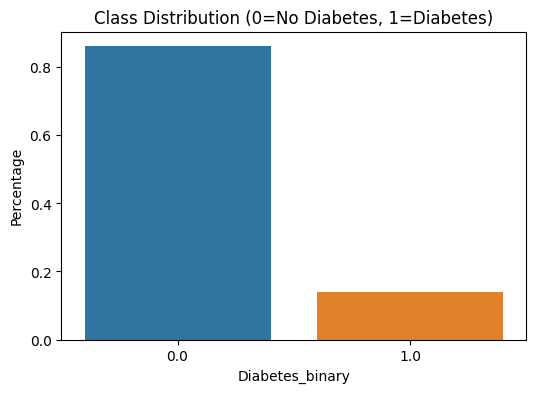

In [3]:
# Check target distribution
target_col = 'Diabetes_binary'
class_dist = df[target_col].value_counts(normalize=True)
print("Class Distribution (normalized):\n", class_dist)

plt.figure(figsize=(6,4))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution (0=No Diabetes, 1=Diabetes)')
plt.xlabel('Diabetes_binary')
plt.ylabel('Percentage')
plt.show()


**Feature Correlation Analysis**  
Identify highly correlated features for potential feature selection.


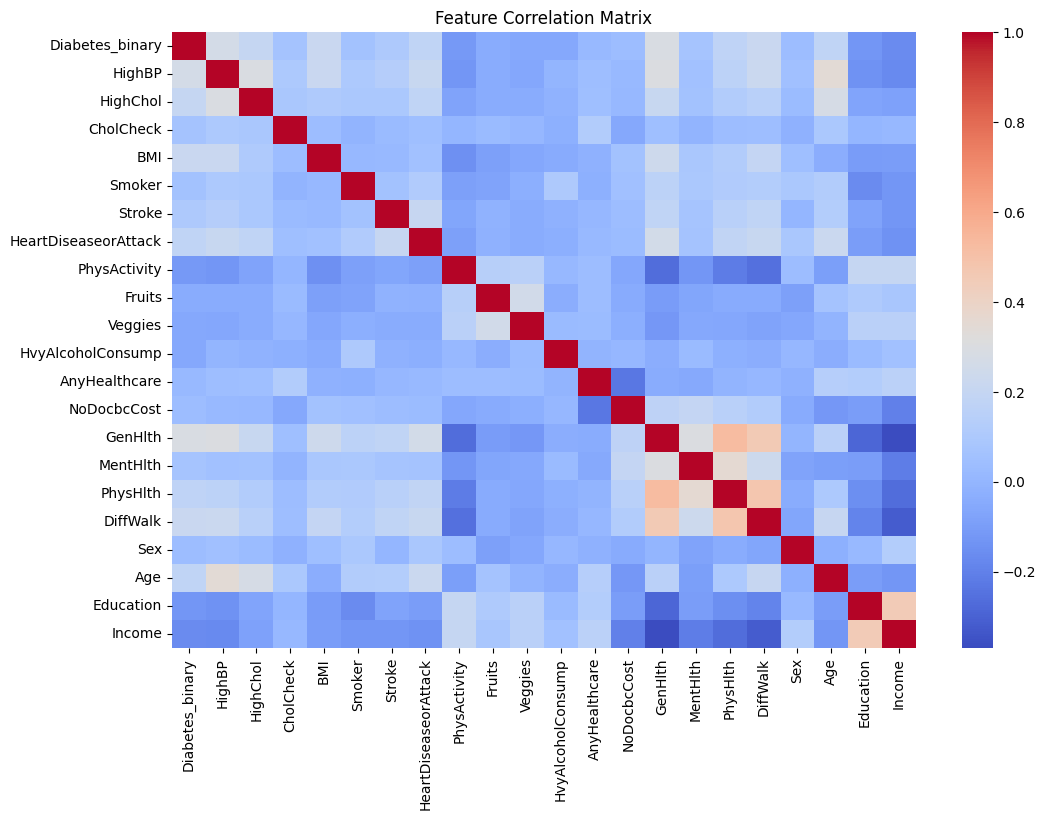

In [4]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

## 2. Data Preprocessing

### 2.1 Feature Selection & Engineering
Remove redundant features based on correlation and domain knowledge.



In [5]:
# Drop non-predictive or highly correlated features
df_processed = df.drop(['AnyHealthcare', 'NoDocbcCost', 'Education', 'Income'], axis=1)

### 2.2 Train-Test Split & Scaling

In [6]:
X = df_processed.drop(target_col, axis=1)
y = df_processed[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (Optional) save the scaler for production
joblib.dump(scaler, 'diabetes_binary_scaler.pkl')

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribution:", Counter(y_train))
print("y_test  distribution:", Counter(y_test))


Shapes -> X_train: (202944, 17) X_test: (50736, 17)
y_train distribution: Counter({0.0: 174667, 1.0: 28277})
y_test  distribution: Counter({0.0: 43667, 1.0: 7069})


### 2.3 Handle Class Imbalance with SMOTE

In [7]:
# # Check the original training distribution
# print("Original y_train Distribution:", Counter(y_train))

# smote_strategy = {1.0: 70000}
# under_strategy = {0.0: 100000}

# pipeline = Pipeline([
#     ('over', SMOTE(sampling_strategy=smote_strategy, random_state=42)),
#     ('under', RandomUnderSampler(sampling_strategy=under_strategy, random_state=42))
# ])

# X_train_res, y_train_res = pipeline.fit_resample(X_train_scaled, y_train)

# print("Resampled y_train Distribution:", Counter(y_train_res))



### 2.4 Convert to PyTorch Datasets

In [8]:
# Convert to PyTorch tensor datasets
train_data = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32, device=device),
    torch.tensor(y_train.values, dtype=torch.long, device=device)
)
test_data = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32, device=device),
    torch.tensor(y_test.values, dtype=torch.long, device=device)
)

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## 3. Deep Learning Model Development

### 3.1 Neural Network Architecture


In [10]:
class DiabetesBinaryNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)  # 2 output classes
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.bn1(x)
        x = torch.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # logits for 2 classes
        return x

model = DiabetesBinaryNet(X_train_scaled.shape[1])
model.to(device)
print(model)

DiabetesBinaryNet(
  (bn1): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=17, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


### 3.2 Define Loss & Optimizer

In [12]:
# class_counts = Counter(y_train_res)

# num_class0 = class_counts[0.0]
# num_class1 = class_counts[1.0]
# total = num_class0 + num_class1

# weight_for_0 = total / (2.0 * num_class0)  # or simply 1 if you're comfortable with resampling
# weight_for_1 = total / (2.0 * num_class1)

# weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32, device=device)
# criterion = nn.CrossEntropyLoss(weight=weights)
# Standard CrossEntropyLoss (since we already did SMOTE + undersampling)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

### 3.3 Training Configuration


In [13]:
epochs = 100
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")


Epoch [5/100] | Train Loss: 0.3160 | Val Loss: 0.3170
Epoch [10/100] | Train Loss: 0.3139 | Val Loss: 0.3154
Epoch [15/100] | Train Loss: 0.3134 | Val Loss: 0.3163
Epoch [20/100] | Train Loss: 0.3136 | Val Loss: 0.3159
Epoch [25/100] | Train Loss: 0.3133 | Val Loss: 0.3156
Epoch [30/100] | Train Loss: 0.3137 | Val Loss: 0.3154
Epoch [35/100] | Train Loss: 0.3133 | Val Loss: 0.3156
Epoch [40/100] | Train Loss: 0.3129 | Val Loss: 0.3154
Epoch [45/100] | Train Loss: 0.3132 | Val Loss: 0.3155
Epoch [50/100] | Train Loss: 0.3133 | Val Loss: 0.3154
Epoch [55/100] | Train Loss: 0.3132 | Val Loss: 0.3158
Epoch [60/100] | Train Loss: 0.3134 | Val Loss: 0.3156
Epoch [65/100] | Train Loss: 0.3135 | Val Loss: 0.3157
Epoch [70/100] | Train Loss: 0.3131 | Val Loss: 0.3154
Epoch [75/100] | Train Loss: 0.3133 | Val Loss: 0.3156
Epoch [80/100] | Train Loss: 0.3133 | Val Loss: 0.3156
Epoch [85/100] | Train Loss: 0.3128 | Val Loss: 0.3153
Epoch [90/100] | Train Loss: 0.3132 | Val Loss: 0.3153
Epoch [95/1

### 3.3 Training Curves

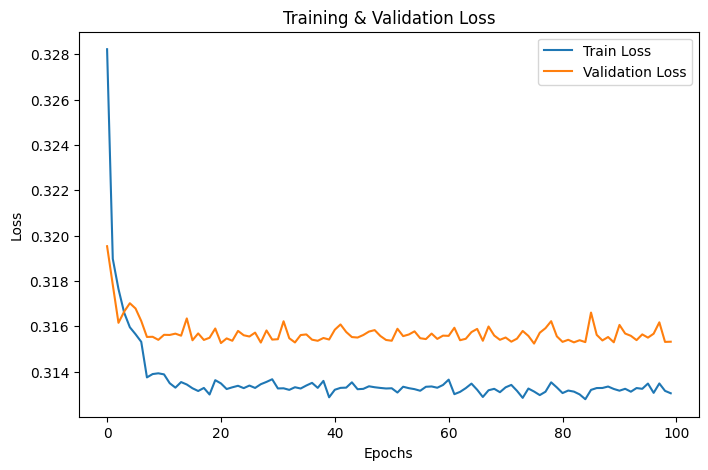

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


## 4. Evaluation & Interpretation

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.88      0.98      0.93     43667
    Diabetes       0.54      0.17      0.26      7069

    accuracy                           0.86     50736
   macro avg       0.71      0.57      0.59     50736
weighted avg       0.83      0.86      0.83     50736



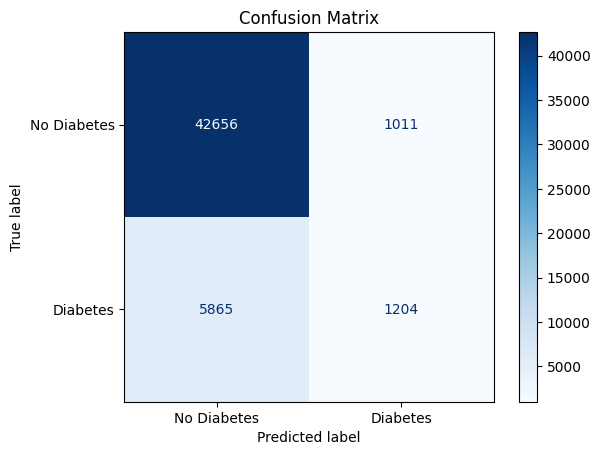

In [15]:
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Diabetes', 'Diabetes']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## 4. Save artifacts for production

In [16]:
# Save model state_dict
torch.save(model.state_dict(), 'diabetes_binary_model.pth')

# Save feature columns
import json
with open('features_binary.json', 'w') as f:
    json.dump(list(X.columns), f)


## 5. Artifact Export for Production


## 5. Visualizations & Analysis

### 5.1 Feature Importance
Using permutation importance (example using test data).


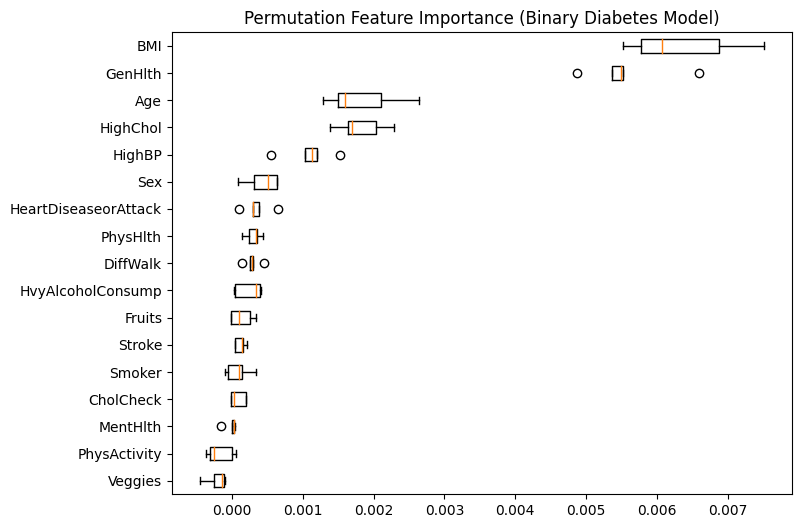

In [18]:
class TorchWrapper(BaseEstimator):
    def __init__(self, model):
        # Use a CPU copy of the model for scikit-learn operations
        self.model = model.to('cpu')
        self.model.eval()

    def fit(self, X, y):
        return self
    
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.numpy()

    def score(self, X, y):
        """Accuracy"""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

wrapped_model = TorchWrapper(model)

# Important: pass NumPy arrays, not PyTorch tensors, for permutation_importance
result = permutation_importance(
    wrapped_model, 
    X_test_scaled, 
    y_test.values, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8,6))
plt.boxplot(
    result.importances[sorted_idx].T, 
    vert=False, 
    labels=np.array(X.columns)[sorted_idx]
)
plt.title("Permutation Feature Importance (Binary Diabetes Model)")
plt.show()


In [19]:
# Define the same input size used before
input_size = 17  # for example, if after feature selection your dataset had 18 columns
global_model = DiabetesBinaryNet(input_size).to(device)




In [20]:
# Load the pretrained weights
global_model.load_state_dict(torch.load("/kaggle/working/diabetes_binary_model.pth", map_location=device))
global_model.eval()

print("Loaded pretrained global model. Ready for federated training!")

Loaded pretrained global model. Ready for federated training!


<ipython-input-20-f9a8bd6d51ff>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load("/kaggle/working/diabetes_binary_model.pth", map_loc

In [21]:
# Suppose X_tensor and y_tensor contain your entire data
# For demonstration, let's create some random data
import torch
import numpy as np

num_samples = 10000
num_features = input_size
X_tensor = torch.randn(num_samples, num_features)
y_tensor = (torch.rand(num_samples) > 0.85).long()  # ~15% positives

# We'll simulate 3 clients by splitting
def split_into_clients(X, y, num_clients=3):
    dataset_size = len(X)
    chunk = dataset_size // num_clients
    clients_data = []
    for i in range(num_clients):
        start = i * chunk
        end = start + chunk if i < num_clients-1 else dataset_size
        X_local = X[start:end]
        y_local = y[start:end]
        clients_data.append((X_local, y_local))
    return clients_data

num_clients = 3
clients_data = split_into_clients(X_tensor, y_tensor, num_clients)


In [26]:
import copy
def local_train(global_model, client_dataset, epochs=2, lr=1e-3):
    """
    Train a local copy of the global model on a single client's data, 
    then return updated model state_dict.
    """
    # 1. Copy global model
    local_model = copy.deepcopy(global_model).to(device)
    local_model.train()

    # 2. Set up local DataLoader
    loader = DataLoader(client_dataset, batch_size=64, shuffle=True)

    optimizer = optim.Adam(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 3. Train
    for _ in range(epochs):
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = local_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # 4. Return local weights
    return local_model.state_dict()


In [27]:
def federated_average(global_model, client_states):
    """
    Averages the weights from each client's state_dict 
    and loads them back into the global model.
    """
    import copy

    new_global_state = copy.deepcopy(global_model.state_dict())

    for key in new_global_state.keys():
        # Cast each client’s tensor to float before stacking
        client_tensors = [client_states[i][key].float() for i in range(len(client_states))]
        stacked_tensors = torch.stack(client_tensors, dim=0)
        new_global_state[key] = torch.mean(stacked_tensors, dim=0)

    global_model.load_state_dict(new_global_state)
    return global_model



In [28]:
federated_rounds = 3
local_epochs = 2

for round_ in range(federated_rounds):
    client_states = []

    # Each client trains locally
    for (X_local, y_local) in clients_data:
        client_dataset = TensorDataset(X_local, y_local)
        local_state = local_train(
            global_model=global_model, 
            client_dataset=client_dataset, 
            epochs=local_epochs, 
            lr=1e-3
        )
        client_states.append(local_state)

    # Server aggregates local updates
    global_model = federated_average(global_model, client_states)

    print(f"Federated Round {round_+1} complete.")


Federated Round 1 complete.
Federated Round 2 complete.
Federated Round 3 complete.


In [29]:
# Suppose we hold out 20% for testing or use the entire data:
test_dataset = TensorDataset(X_tensor, y_tensor)
test_loader = DataLoader(test_dataset, batch_size=128)

global_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = global_model(X_batch)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

acc = correct / total
print(f"Final Global Model Accuracy: {acc:.4f}")


Final Global Model Accuracy: 0.8519
